### Importing necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import datasets
from torchvision import transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Download datasets and Transform images

Get the "CIFAR-10" image data from the source. Then split 20% of train-set as validation-set. 
The batch size is 100 that means 100 samples per batch to load.

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.CIFAR10("./data", download = True, train = True, transform = transform)
testset = datasets.CIFAR10("./data", download = True, train = False, transform = transform)

indexes = list(range(len(trainset)))
np.random.shuffle(indexes)
split_size = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indexes[:split_size])
valid_sample = SubsetRandomSampler(indexes[split_size:])

trainloader = DataLoader(trainset, sampler = train_sample, batch_size = 100)
validloader = DataLoader(trainset, sampler = valid_sample, batch_size = 100)
testloader = DataLoader(testset, batch_size = 100, shuffle = True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Visualize a Batch of Training Data

To see some images and their labels from train dataset I use matplotlib.

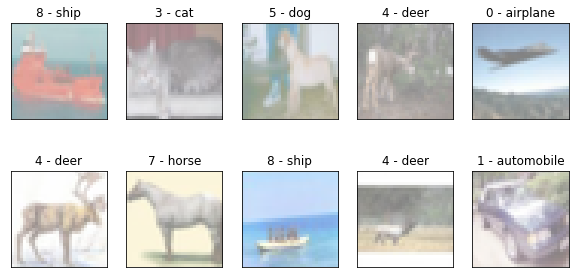

In [5]:
label_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]
images, labels = iter(trainloader).next()
fig = plt.figure(figsize=(10,5))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    image = images[i].cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    plt.imshow(image)
    ax.set_title(str(labels[i].item())+' - '+label_names[labels[i].item()])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Define the Network Architecture, train the network and test the trained model

### Define the train and test methods

This method will train the model. Forward and backward phases are implemented. At the end, train loss and validation loss are printed for each epoch.

In [10]:
def train(n_epochs, model, optimizer, criterion):
  model.train()
  
  for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    for data, target in trainloader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    for data, target in validloader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)

    print('Epoch {} ---> Training Loss: {:.4f} \tValidation Loss: {:.4f}'.format(epoch + 1, train_loss, valid_loss))

Test the traind model with test dataset and report the accuracy for each class and overall accuracy. The confusion matrix is also printed by this function. 

In [11]:
def test(model, criterion):
  model.eval()

  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  y_pred = []
  y_true = []
  test_loss = 0.0
  for data, target in testloader:
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      pred = output.argmax(1)
      correct = np.squeeze(pred.eq(target.data.view_as(pred)))
      for i in range(100):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1
          
      output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
      y_pred.extend(output) 
      
      target = target.data.cpu().numpy()
      y_true.extend(target)
  test_loss = test_loss/len(testloader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(10):
      if class_total[i] > 0:
          print('Test Accuracy of label %2s: %2d%% (%2d/%2d)' % (
              str(i), 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
          
  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))
  
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in label_names], columns = [i for i in label_names])
  plt.figure(figsize = (10,5))
  sn.heatmap(df_cm, annot=True)

### First CNN Model
Four convolution layers, using batch normalization, using ReLU as activation function, two avrage pooling layer and fully connected network with two layers.

In [18]:
class CNN1(nn.Module):
  def __init__(self, in_channels, n_classes):
    super(CNN1, self).__init__()
    self.conv0 = nn.Conv2d(in_channels, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()

    self.conv1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(64)

    self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(64)

    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(64)

    self.avg_pool = nn.AvgPool2d(2)

    self.fc1 = nn.Linear(4096, 64)
    self.fc2 = nn.Linear(64, n_classes)

  def forward(self, x):
    out = self.conv0(x)
    out = self.bn(out)
    out = self.relu(out)

    out = self.conv1(out)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.avg_pool(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)
    out = self.relu(out)
    out = self.avg_pool(out)
    

    out = out.view(out.size(0), -1)

    out = self.fc1(out)
    out = F.relu(out)

    out = self.fc2(out)

    return out

Train the model with 10 epochs and using Adam optimizer with learning rate = 0.001 and crossEntropy as loss function.

In [19]:
n_epochs = 10
cnn_model = CNN1(in_channels=3, n_classes=10).to(device)
optimizer = optim.Adam(cnn_model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

train(n_epochs, cnn_model, optimizer, criterion)

Epoch 1 ---> Training Loss: 1.6231 	Validation Loss: 1.4128
Epoch 2 ---> Training Loss: 1.2535 	Validation Loss: 1.2477
Epoch 3 ---> Training Loss: 1.0665 	Validation Loss: 1.0897
Epoch 4 ---> Training Loss: 0.9239 	Validation Loss: 1.0577
Epoch 5 ---> Training Loss: 0.7984 	Validation Loss: 0.9953
Epoch 6 ---> Training Loss: 0.6919 	Validation Loss: 0.9471
Epoch 7 ---> Training Loss: 0.6278 	Validation Loss: 0.9482
Epoch 8 ---> Training Loss: 0.5473 	Validation Loss: 0.9201
Epoch 9 ---> Training Loss: 0.4651 	Validation Loss: 0.9604
Epoch 10 ---> Training Loss: 0.3989 	Validation Loss: 0.9454


Test Loss: 0.941949

Test Accuracy of label  0: 69% (696/1000)
Test Accuracy of label  1: 77% (778/1000)
Test Accuracy of label  2: 63% (634/1000)
Test Accuracy of label  3: 53% (534/1000)
Test Accuracy of label  4: 48% (486/1000)
Test Accuracy of label  5: 62% (622/1000)
Test Accuracy of label  6: 78% (784/1000)
Test Accuracy of label  7: 70% (703/1000)
Test Accuracy of label  8: 84% (847/1000)
Test Accuracy of label  9: 84% (843/1000)

Test Accuracy (Overall): 69% (6927/10000)


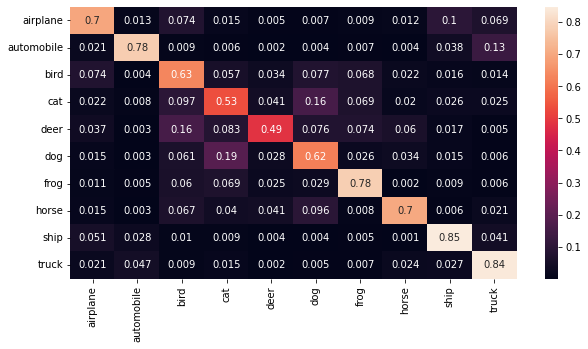

In [22]:
test(cnn_model, criterion)



---



### Second CNN Model
Six convolution layers, using batch normalization, using ReLU as activation function, three avrage pooling layers and fully connected network with two layers.

In [25]:
class CNN2(nn.Module):
  def __init__(self, in_channels, n_classes):
    super(CNN2, self).__init__()
    self.conv0 = nn.Conv2d(in_channels, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()

    self.conv1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(64)

    self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(64)

    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(64)

    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(64)

    self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.bn5 = nn.BatchNorm2d(64)

    self.avg_pool = nn.AvgPool2d(2)

    self.fc1 = nn.Linear(1024, 64)
    self.fc2 = nn.Linear(64, n_classes)

  def forward(self, x):
    out = self.conv0(x)
    out = self.bn(out)
    out = self.relu(out)

    out = self.conv1(out)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.avg_pool(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)
    out = self.relu(out)
    out = self.avg_pool(out)

    out = self.conv4(out)
    out = self.bn4(out)
    out = self.relu(out)

    out = self.conv5(out)
    out = self.bn5(out)
    out = self.relu(out)
    out = self.avg_pool(out)

    out = out.view(out.size(0), -1)

    out = self.fc1(out)
    out = F.relu(out)

    out = self.fc2(out)

    return out

Train the model with 10 epochs and using Adam optimizer with learning rate = 0.001 and crossEntropy as loss function.

In [26]:
n_epochs = 10
cnn_model = CNN2(in_channels=3, n_classes=10).to(device)
optimizer = optim.Adam(cnn_model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

train(n_epochs, cnn_model, optimizer, criterion)

Epoch 1 ---> Training Loss: 1.6449 	Validation Loss: 1.4274
Epoch 2 ---> Training Loss: 1.2905 	Validation Loss: 1.2256
Epoch 3 ---> Training Loss: 1.1006 	Validation Loss: 1.0781
Epoch 4 ---> Training Loss: 0.9588 	Validation Loss: 0.9974
Epoch 5 ---> Training Loss: 0.8252 	Validation Loss: 0.9361
Epoch 6 ---> Training Loss: 0.7391 	Validation Loss: 0.9118
Epoch 7 ---> Training Loss: 0.6547 	Validation Loss: 0.8477
Epoch 8 ---> Training Loss: 0.5845 	Validation Loss: 0.8348
Epoch 9 ---> Training Loss: 0.5024 	Validation Loss: 0.8542
Epoch 10 ---> Training Loss: 0.4308 	Validation Loss: 0.8363


Test Loss: 0.817511

Test Accuracy of label  0: 74% (749/1000)
Test Accuracy of label  1: 86% (869/1000)
Test Accuracy of label  2: 48% (481/1000)
Test Accuracy of label  3: 50% (503/1000)
Test Accuracy of label  4: 69% (691/1000)
Test Accuracy of label  5: 69% (690/1000)
Test Accuracy of label  6: 73% (736/1000)
Test Accuracy of label  7: 83% (835/1000)
Test Accuracy of label  8: 85% (858/1000)
Test Accuracy of label  9: 86% (869/1000)

Test Accuracy (Overall): 72% (7281/10000)


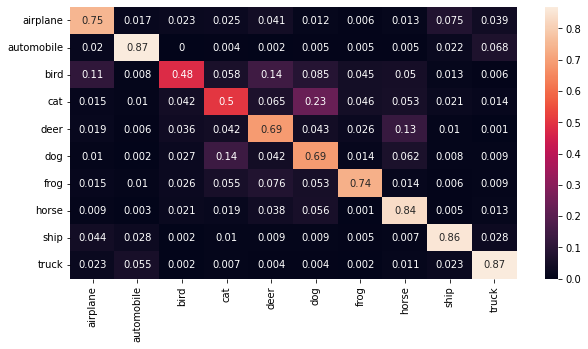

In [27]:
test(cnn_model, criterion)

after adding two convolution layers to the network, the accuracy would be increased.

---



### Third CNN Model
Six convolution layers, without batch normalization, using ReLU as activation function, three avrage pooling layers and fully connected network with two layers.

In [28]:
class CNN3(nn.Module):
  def __init__(self, in_channels, n_classes):
    super(CNN3, self).__init__()
    self.conv0 = nn.Conv2d(in_channels, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
    self.relu = nn.ReLU()

    self.conv1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)

    self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)

    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)

    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)

    self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)

    self.avg_pool = nn.AvgPool2d(2)

    self.fc1 = nn.Linear(1024, 64)
    self.fc2 = nn.Linear(64, n_classes)

  def forward(self, x):
    out = self.conv0(x)
    out = self.relu(out)

    out = self.conv1(out)
    out = self.relu(out)
    out = self.avg_pool(out)

    out = self.conv2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.relu(out)
    out = self.avg_pool(out)

    out = self.conv4(out)
    out = self.relu(out)

    out = self.conv5(out)
    out = self.relu(out)
    out = self.avg_pool(out)

    out = out.view(out.size(0), -1)

    out = self.fc1(out)
    out = F.relu(out)

    out = self.fc2(out)

    return out

Train the model with 10 epochs and using Adam optimizer with learning rate = 0.001 and crossEntropy as loss function.

In [29]:
n_epochs = 10
cnn_model = CNN3(in_channels=3, n_classes=10).to(device)
optimizer = optim.Adam(cnn_model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

train(n_epochs, cnn_model, optimizer, criterion)

Epoch 1 ---> Training Loss: 2.1053 	Validation Loss: 1.9727
Epoch 2 ---> Training Loss: 1.8726 	Validation Loss: 1.7847
Epoch 3 ---> Training Loss: 1.7048 	Validation Loss: 1.6392
Epoch 4 ---> Training Loss: 1.5866 	Validation Loss: 1.5411
Epoch 5 ---> Training Loss: 1.4806 	Validation Loss: 1.4696
Epoch 6 ---> Training Loss: 1.3680 	Validation Loss: 1.3613
Epoch 7 ---> Training Loss: 1.2815 	Validation Loss: 1.3956
Epoch 8 ---> Training Loss: 1.2137 	Validation Loss: 1.2634
Epoch 9 ---> Training Loss: 1.1363 	Validation Loss: 1.2519
Epoch 10 ---> Training Loss: 1.0859 	Validation Loss: 1.2525


Test Loss: 1.243295

Test Accuracy of label  0: 64% (641/1000)
Test Accuracy of label  1: 70% (705/1000)
Test Accuracy of label  2: 52% (523/1000)
Test Accuracy of label  3: 43% (431/1000)
Test Accuracy of label  4: 42% (429/1000)
Test Accuracy of label  5: 37% (371/1000)
Test Accuracy of label  6: 64% (646/1000)
Test Accuracy of label  7: 61% (618/1000)
Test Accuracy of label  8: 74% (742/1000)
Test Accuracy of label  9: 57% (579/1000)

Test Accuracy (Overall): 56% (5685/10000)


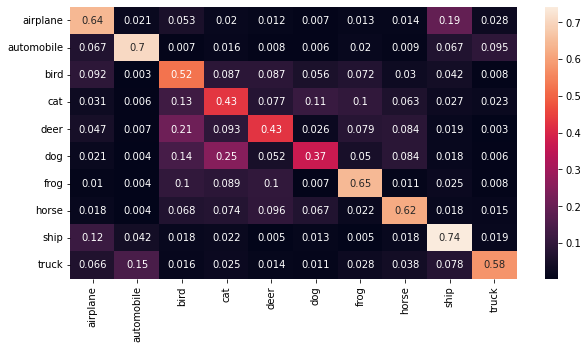

In [30]:
test(cnn_model, criterion)

as you can see when we don't use batch normalization, the accuracy of the medel decreases about 16%.


---



### Fourth CNN Model
I change the arctichture of network to achieve higher accuracy.

Seven convolution layers, using batch normalization, using ReLU as activation function, three Max pooling layers, global avrage polling to reduce the parameters and fully connected network with one layer.

I also change the input and output channels of hidden layers.

In [31]:
class CNN4(nn.Module):
  def __init__(self, in_channels, n_classes):
    super(CNN4, self).__init__()
    self.conv0 = nn.Conv2d(in_channels, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn = nn.BatchNorm2d(32)
    self.relu = nn.ReLU()

    self.conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(64)

    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(128)

    self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(128)

    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(256)

    self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.bn5 = nn.BatchNorm2d(256)

    self.conv6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
    self.bn6 = nn.BatchNorm2d(512)

    self.max_pool = nn.MaxPool2d(2,2)

    # self.fc1 = nn.Linear(4096, 1024)
    # self.fc2 = nn.Linear(1024, 256)
    self.gap = nn.AdaptiveAvgPool2d(1)
    self.fc3 = nn.Linear(512, n_classes)

  def forward(self, x):
    out = self.conv0(x)
    out = self.bn(out)
    out = self.relu(out)

    out = self.conv1(out)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.max_pool(out)
    
    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)
    out = self.relu(out)
    out = self.max_pool(out)

    out = self.conv4(out)
    out = self.bn4(out)
    out = self.relu(out)

    out = self.conv5(out)
    out = self.bn5(out)
    out = self.relu(out)
    out = self.max_pool(out)

    out = self.conv6(out)
    out = self.bn6(out)
    out = self.relu(out)

    out = self.gap(out)
    out = torch.flatten(out, 1) 
    # out = self.fc1(out)
    # out = self.relu(out)
    # out = self.fc2(out)
    # out = self.relu(out)

    out = self.fc3(out)

    return out

Train the model with 15 epochs and using Adam optimizer with learning rate = 0.001 and crossEntropy as loss function.

In [38]:
n_epochs = 15
cnn_model = CNN4(in_channels=3, n_classes=10).to(device)
optimizer = optim.Adam(cnn_model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

train(n_epochs, cnn_model, optimizer, criterion)

Epoch 1 ---> Training Loss: 1.5901 	Validation Loss: 1.3719
Epoch 2 ---> Training Loss: 1.2297 	Validation Loss: 1.1381
Epoch 3 ---> Training Loss: 1.0021 	Validation Loss: 0.9946
Epoch 4 ---> Training Loss: 0.8464 	Validation Loss: 0.9329
Epoch 5 ---> Training Loss: 0.7402 	Validation Loss: 0.8658
Epoch 6 ---> Training Loss: 0.6241 	Validation Loss: 0.8163
Epoch 7 ---> Training Loss: 0.5150 	Validation Loss: 0.8409
Epoch 8 ---> Training Loss: 0.4099 	Validation Loss: 0.8208
Epoch 9 ---> Training Loss: 0.3377 	Validation Loss: 0.8173
Epoch 10 ---> Training Loss: 0.2424 	Validation Loss: 0.8640
Epoch 11 ---> Training Loss: 0.1692 	Validation Loss: 0.8698
Epoch 12 ---> Training Loss: 0.1254 	Validation Loss: 0.9463
Epoch 13 ---> Training Loss: 0.1024 	Validation Loss: 0.9477
Epoch 14 ---> Training Loss: 0.0657 	Validation Loss: 0.9918
Epoch 15 ---> Training Loss: 0.0535 	Validation Loss: 1.0192


Test Loss: 0.999675

Test Accuracy of label  0: 79% (796/1000)
Test Accuracy of label  1: 86% (867/1000)
Test Accuracy of label  2: 61% (616/1000)
Test Accuracy of label  3: 61% (610/1000)
Test Accuracy of label  4: 75% (751/1000)
Test Accuracy of label  5: 70% (704/1000)
Test Accuracy of label  6: 77% (778/1000)
Test Accuracy of label  7: 77% (775/1000)
Test Accuracy of label  8: 85% (857/1000)
Test Accuracy of label  9: 85% (857/1000)

Test Accuracy (Overall): 76% (7611/10000)


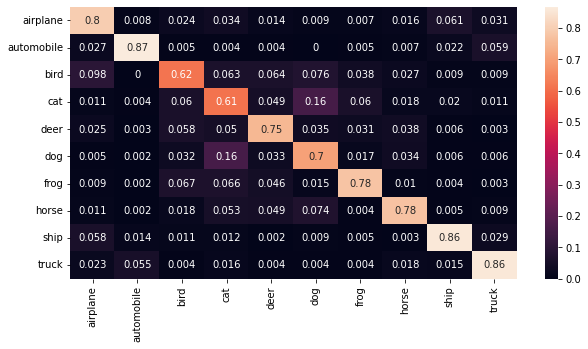

In [39]:
test(cnn_model, criterion)

With this architecture the accuracy of model be increased to 76%.


---



### Fifth CNN Model
I change the arctichture of network to achieve higher accuracy.

Seven convolution layers, using batch normalization, using ReLU as activation function, using dropout, three Max pooling layers, global avrage polling to reduce the number parameters and fully connected network with one layer.

I also change the input and output channels of hidden layers.

In [40]:
class CNN5(nn.Module):
  def __init__(self, in_channels, n_classes):
    super(CNN5, self).__init__()
    self.conv0 = nn.Conv2d(in_channels, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.bn = nn.BatchNorm2d(32)
    self.relu = nn.ReLU()

    self.conv1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)

    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(64)

    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(64)
    
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(128)

    self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.bn5 = nn.BatchNorm2d(128)

    self.conv6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.bn6 = nn.BatchNorm2d(256)

    # self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
    # self.bn7 = nn.BatchNorm2d(256)

    # self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
    # self.bn8 = nn.BatchNorm2d(512)
    self.dropout = nn.Dropout(0.5)
    self.max_pool = nn.MaxPool2d(2,2)

    # self.fc1 = nn.Linear(4096, 1024)
    # self.fc2 = nn.Linear(1024, 256)
    self.gap = nn.AdaptiveAvgPool2d(1)
    self.fc3 = nn.Linear(256, n_classes)

  def forward(self, x):
    out = self.conv0(x)
    out = self.bn(out)
    out = self.relu(out)

    out = self.conv1(out)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.max_pool(out)
    
    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)
    out = self.relu(out)
    out = self.max_pool(out)

    out = self.conv4(out)
    out = self.bn4(out)
    out = self.relu(out)

    out = self.conv5(out)
    out = self.bn5(out)
    out = self.relu(out)
    out = self.max_pool(out)

    out = self.conv6(out)
    out = self.bn6(out)
    out = self.relu(out)

    # out = self.conv7(out)
    # out = self.bn7(out)
    # out = self.relu(out)
    # out = self.max_pool(out)

    out = self.gap(out)
    out = torch.flatten(out, 1) 
    out = self.dropout(out)

    out = self.fc3(out)

    return out

In [41]:
n_epochs = 15
cnn_model = CNN5(in_channels=3, n_classes=10).to(device)
optimizer = optim.Adam(cnn_model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

train(n_epochs, cnn_model, optimizer, criterion)

Epoch 1 ---> Training Loss: 1.6450 	Validation Loss: 1.4456
Epoch 2 ---> Training Loss: 1.2990 	Validation Loss: 1.2255
Epoch 3 ---> Training Loss: 1.1079 	Validation Loss: 1.1350
Epoch 4 ---> Training Loss: 0.9608 	Validation Loss: 1.0637
Epoch 5 ---> Training Loss: 0.8546 	Validation Loss: 0.9524
Epoch 6 ---> Training Loss: 0.7585 	Validation Loss: 0.9109
Epoch 7 ---> Training Loss: 0.6597 	Validation Loss: 0.8757
Epoch 8 ---> Training Loss: 0.5607 	Validation Loss: 0.9137
Epoch 9 ---> Training Loss: 0.4832 	Validation Loss: 0.8649
Epoch 10 ---> Training Loss: 0.3976 	Validation Loss: 0.9030
Epoch 11 ---> Training Loss: 0.3088 	Validation Loss: 0.9012
Epoch 12 ---> Training Loss: 0.2598 	Validation Loss: 0.9564
Epoch 13 ---> Training Loss: 0.2164 	Validation Loss: 0.9731
Epoch 14 ---> Training Loss: 0.1486 	Validation Loss: 0.9896
Epoch 15 ---> Training Loss: 0.1076 	Validation Loss: 1.0569


Test Loss: 0.956891

Test Accuracy of label  0: 78% (788/1000)
Test Accuracy of label  1: 86% (865/1000)
Test Accuracy of label  2: 56% (568/1000)
Test Accuracy of label  3: 49% (493/1000)
Test Accuracy of label  4: 71% (710/1000)
Test Accuracy of label  5: 71% (717/1000)
Test Accuracy of label  6: 83% (831/1000)
Test Accuracy of label  7: 73% (731/1000)
Test Accuracy of label  8: 88% (880/1000)
Test Accuracy of label  9: 85% (854/1000)

Test Accuracy (Overall): 74% (7437/10000)


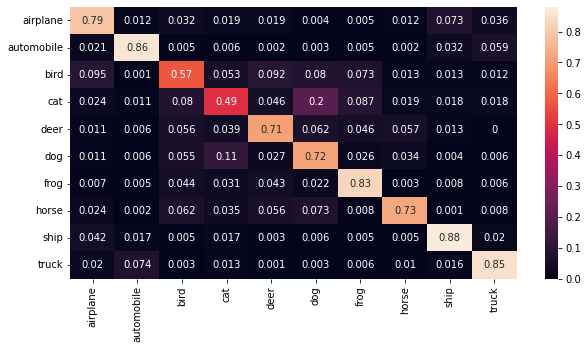

In [42]:
test(cnn_model, criterion)

I desgined 5 diffrent models and after train with 10 and 15 epochs I reach 76% accuracy as the best. 